## Assignment 6 - Adaptive Grids


### 6.1 - Import the Grid-class
In the assignment folder you can find a python file called ```grid.py```. Import this file and create a grid called ```g``` of the unitsquare.

In [3]:
import grid 
g = grid.Grid(0,1,0,1,10,10)

### 6.2 - refined Grid
Write a class ```GridAdapter``` that handles the adaptive refinement of a grid. The constructor should have the following input:

<b> INPUT </b>: A grid ```grid```

Hint: The ```GridAdapter``` is NOT a childclass of ```Grid```. It is a class which has a grid-Class as a property.  

#### 6.2.1 Refinement

Write a function ```refine``` of this class that refines the grid of the ```GridAdapter``` adaptivly. You aren't limited in the number of helper functions.

<b> INPUT </b>:
- ```f```, a lambda function $f: \mathbb{R}^2 \longrightarrow \{true, false \}$. You should refine every cell where the evalution of $f$ at the center of the cell returns $true$.
- ```n```, an integer $n$ which gives the number of refinements. You should $n$ times refine the grid according to the value of $f$.

<b> ATTENTION </b>:
If you insert a new triangle in cells, always make sure that the numbering scheme is correct, therefore mathematically positive and starting with the index opposed to the longest edge. 

#### 6.2.2 Show

Write a property ```show``` which shows the grid.



### Hints for 6.2.1

The grid class has a new property ```isBoundaryPoint()```. You can use it to check if a inserted node is boundaryNode or not. <br>
<b>INPUT:</b> ```x``` single point ```np.array([x,y])```. <br>
<b>OUTPUT:</b> boolean. ```True``` if ```x``` is on the Boundary of the domain. 

If you need some additional inspiration you can for example use the following additional class variables and follow the plan given below:

<b> POSSIBLE ADDITIONAL CLASS VARIABLES </b>:

- ```indMarkedCells``` list, of indices of the cells marked for the refinment.
- ```indHangingNodes``` list, where you collect the indices of all points that could be hanging nodes in the moment
- ```indHangingNodesShared``` list, where you collect the edges which could contain a hanging Node in the moment

For example: If you insert the point with index $10$ on the edge between the points $2$ and $3$ and point $10$ is no boundary point, you insert $10$ in ```indHangingNodes``` and $\lbrack 2, 3 \rbrack$ in ```indHangingNodesShared```

<b> PLAN </b>:
 
- Write a function ```markCells``` in which you construct a list with the indices of all cells which you have to refine because $f$ evaluates to true in the center of the cell

- Write a function ```refineMarkedCells``` where you iterate over all marked cells. Calculate the coordinates of the new Point. If this point exists in the points array than your are closing a hanging node. If no, add it to the points array of the grid property and add the index to the hanging nodes and update ```hangingNodesShared```, if it is not a boundary point. In any case update the cells array and be careful with the numbering.   
 
- Write a function ```markHangingCells``` which marks all the cells we have to refine to close the hanging nodes. In other words, all cells that have an edge which is contained in ```indHangingNodesShared```.  

- In your function ```refine``` mark all the cells according to the value of $f$ and refine them. After that refine all cells with hanging nodes again until there are no hanging nodes left. Repeat this $n$ times.

In [32]:
import numpy as np
import matplotlib.pyplot as plt

class GridAdapter():
  def __init__(self,grid):
    self.indHangingNodes = []  # store the hanging nodes
    self.indHangingNodesShared = []   # points corresponding to the hanging node
    self.indMarkedCells=[]   
    self.grid = grid

  def markCells(self,f):  #       Nc x 3 x 2  
    cellCenters = np.mean(self.grid.points[self.grid.cells],axis=1)
    self.indMarkedCells = np.where(f(cellCenters[:,0],cellCenters[:,1]))[0] # indices of the marked triangles

  def refineMarkedCells(self):     
    for index in self.indMarkedCells:
      cell = np.copy(self.grid.cells[index]) # extracting the indices of the triangle, inital a new pointer 
      points = self.grid.points[cell]  # extracting the points building this triangle
        
      newPoint = 0.5*(points[1]+points[2]) # defining the point
 
      # check if the new point is new hanging node or exists (closing the hanging node)
      dists = np.linalg.norm(self.grid.points-newPoint,axis=1) 
      if min(dists)<1e-6:
       # new point exists 
        indNewPoint = np.where(dists<1e-6)[0][0]
        ind = np.where(self.indHangingNodes==indNewPoint)[0][0]
        self.indHangingNodes.remove(indNewPoint)
        self.indHangingNodesShared.pop(ind)
      else: 
        # insert the new point
        indNewPoint = len(self.grid.points)
        if not self.grid.isBoundaryPoint(newPoint):
          self.indHangingNodes.append(indNewPoint)
          self.indHangingNodesShared.append(self.grid.cells[index][[1,2]])
        #endif
      #endif

      # add the new point 
      self.grid.points = np.vstack( [self.grid.points , newPoint])
        
      # modify the existing cell
      d1 = np.sum((self.grid.points[cell[0]] - self.grid.points[cell[1]])**2)
      d2 = np.sum((self.grid.points[indNewPoint] - self.grid.points[cell[1]])**2)
      d3 = np.sum((self.grid.points[cell[0]] - self.grid.points[indNewPoint])**2)    
        
      if d1 > max(d2,d3):  
        self.grid.cells[index,:] = np.array([indNewPoint , cell[0] , cell[1]  ])
      elif d2 > max(d1,d3):
        self.grid.cells[index,:] = np.array([cell[0] , cell[1] , indNewPoint ]) 
      else:      
        self.grid.cells[index,:] = np.array([cell[1] , indNewPoint  , cell[0] ])     
      
    
      # add on the new cell
      d1 = np.sum((self.grid.points[cell[0]] - self.grid.points[cell[2]])**2)
      d2 = np.sum((self.grid.points[indNewPoint] - self.grid.points[cell[2]])**2)
      d3 = np.sum((self.grid.points[cell[0]] - self.grid.points[indNewPoint])**2)    
        
      if d1 > max(d2,d3):  
        self.grid.cells = np.append( self.grid.cells , np.array([[ indNewPoint , cell[2] , cell[0]  ]]), axis=0   ) # new 1 2    
      elif d2 > max(d1,d3):
        self.grid.cells = np.append( self.grid.cells , np.array([[ cell[0] , indNewPoint , cell[2]  ]]), axis=0   ) # new 1 2    
      else:      
        self.grid.cells = np.append( self.grid.cells , np.array([[ cell[2] , cell[0] , indNewPoint]]), axis=0   ) # new 1 2    
    
    #endfor   
    self.indMarkedCells = []
  #endfunction

  def markHangingCells(self): 
    for shared in self.indHangingNodesShared:
      ind = np.where(
          np.sum(self.grid.cells == shared[0],axis=1)*   #   --> Nc 
          np.sum(self.grid.cells == shared[1],axis=1)    #   --> Nc 
      )[0][0]   # getting the index of the trangle left
      self.indMarkedCells.append(ind)
    #endfor
  #end function
    
  def refine(self,f,n=1):
    for i in range(n):
      self.markCells(f)  # mark the cells by f 
      self.refineMarkedCells()
      while len(self.indHangingNodes)>0:
        self.markHangingCells()  # mark the cells by check if there an hanging 
        self.refineMarkedCells()
      #endwhile
    #endfor
  #endfunction

  def show(self):
    self.grid.show()
    
  def getGrid(self):
    return self.grid

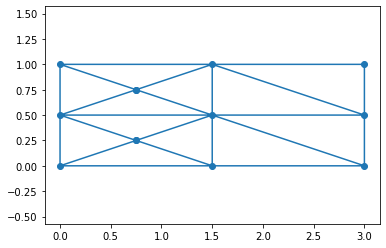

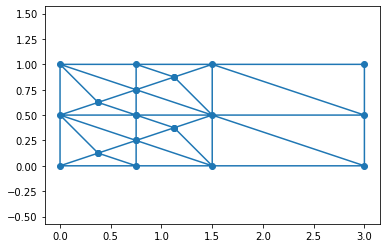

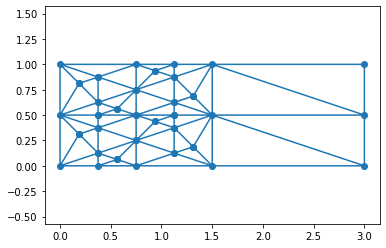

In [33]:
try:
  g = grid.Grid(0,3,0,1,3,3)
except:
  g = Grid(0,1,0,1,5,5)

adapter = GridAdapter(g)
f = lambda x,y: x<1.6

adapter.refine(f,1)
adapter.show()

adapter.refine(f,1)
adapter.show()

adapter.refine(f,1)
adapter.show()

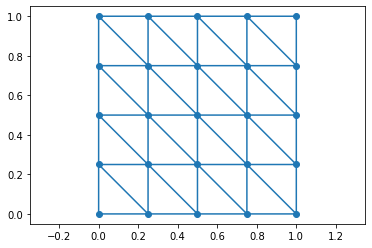

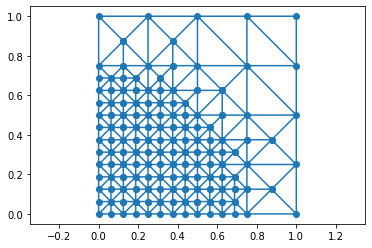

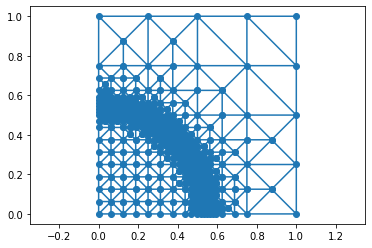

In [34]:
try:
  g = grid.Grid(0,1,0,1,5,5)
except:
  g = Grid(0,1,0,1,5,5)

adapter = GridAdapter(g)
adapter.show()

f = lambda x,y : (x**2+y**2<0.5) 
adapter.refine(f,4)
adapter.show()

f = lambda x,y : (x**2+y**2<0.35)*(x**2+y**2>0.25) 
adapter.refine(f,4)
adapter.show()